In [2]:
import pandas as pd
import numpy as np
import cv2, os
import glob
import matplotlib.pyplot as plt
import pathlib
import shutil
from sklearn.model_selection import train_test_split
import pathlib


In [5]:
def normalize_keypoints(keypoints, width, height):
    normalized_keypoints = []
    for x, y in keypoints:
        x_norm = x / width
        y_norm = y / height
        normalized_keypoints.append([x_norm, y_norm])
    return normalized_keypoints


def xyxy_to_xywh_normalized(xyxy_bbox, image_width, image_height):
    x_min, y_min, x_max, y_max = xyxy_bbox
    width = x_max - x_min
    height = y_max - y_min
    x_center = x_min + width / 2
    y_center = y_min + height / 2

    x_center_normalized = x_center / image_width
    y_center_normalized = y_center / image_height
    width_normalized = width / image_width
    height_normalized = height / image_height

    return x_center_normalized, y_center_normalized, width_normalized, height_normalized


def keypoints_to_bbox(keypoints):
    x_coordinates = [point[0] for point in keypoints]
    y_coordinates = [point[1] for point in keypoints]

    x_min = min(x_coordinates)
    y_min = min(y_coordinates)
    x_max = max(x_coordinates)
    y_max = max(y_coordinates)
    return x_min, y_min, x_max, y_max


def show_polygons(dir_image, url, points):
    image = cv2.imread(os.path.join(dir_image, os.path.basename(url)))
    pts = np.array(points, np.int32)
    pts = pts.reshape((-1, 1, 2))
    image = cv2.polylines(image, [pts], True, (0,255,255), 5)

    plt.imshow(image)
    plt.show()


def show_bounding_box(dir_image, url, bboxes):
    image = cv2.imread(os.path.join(dir_image, os.path.basename(url)))
    start_pt = (int(bboxes[0]), int(bboxes[1]))
    end_pt = (int(bboxes[2]), int(bboxes[3]))

    print(start_pt)
    print(end_pt)

    image = cv2.rectangle(image, start_pt, end_pt, (0, 255, 0), 2) 
    plt.imshow(image)
    plt.show()


def move_file(source_folder, destination_folder, file_name):
    # Check if the source file exists
    source_path = os.path.join(source_folder, file_name)
    if not os.path.exists(source_path):
        print(f"Source: {source_path}, file '{file_name}' not found in '{source_folder}'.")
        return
    
    # Check if the destination folder exists
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder, exist_ok=True)  # Create the destination folder if it doesn't exist
    
    # Construct the destination path
    destination_path = os.path.join(destination_folder, file_name)
    
    try:
        shutil.move(source_path, destination_path)
        print(f"File '{file_name}' moved from '{source_folder}' to '{destination_folder}'.")
    except Exception as e:
        print(f"Failed to move the file: {e}")



In [ ]:
root = "/home/fit/optivisionlab/scan-bill/bill_printed"
dires = os.listdir(root)
for dir in dires:
    print(dir)
    os.makedirs(os.path.join(root, dir, "label_txt"), exist_ok=True)
    os.makedirs(os.path.join(root, dir, "label_json"), exist_ok=True)
    os.makedirs(os.path.join(root, dir, "images"), exist_ok=True)
    os.system(f"mv {os.path.join(root, dir, '*.json')} {os.path.join(root, dir, 'label_json')}")
    os.system(f"mv {os.path.join(root, dir, '*.jpg')} {os.path.join(root, dir, 'images')}")
    files_json = glob.glob(os.path.join(root, dir, "label_json/*"))
    for file in files_json:
        print("file >>> ", file)
        _, _, label, file_name, _, imageHeight, imageWidth = pd.read_json(file, orient='index').values
        keyptsn = normalize_keypoints(keypoints=np.array(label[0][0]['points']), width=imageWidth[0], height=imageHeight[0])
        boxes = keypoints_to_bbox(keypoints=np.array(label[0][0]['points']))
        xywhn = xyxy_to_xywh_normalized(xyxy_bbox=boxes, image_width=imageWidth[0], image_height=imageHeight[0])
        line = (0, *xywhn, *keyptsn[0], *keyptsn[1], *keyptsn[2], *keyptsn[3])
        with open(os.path.join(root, dir, 'label_txt', pathlib.Path(file_name[0]).stem + '.txt'), 'w') as f:
            f.write(('%g ' * len(line)).rstrip() % line + '\n')

In [ ]:
root = "/home/fit/optivisionlab/scan-bill/bill_printed"
dires = os.listdir(root)
for dir in dires:
    files = glob.glob(os.path.join(root, dir, "images/*.jpg"))
    print(dir, len(files))
    if len(files) > 10:
        print("process >>>>>> ", dir, len(files))
        train, val= train_test_split(files, test_size=0.3, random_state=1000, shuffle=True)
        print(len(train), len(val))

        os.makedirs(os.path.join(root, dir, "images/train"), exist_ok=True)
        os.makedirs(os.path.join(root, dir, "images/val"), exist_ok=True)
        os.makedirs(os.path.join(root, dir, "labels/train"), exist_ok=True)
        os.makedirs(os.path.join(root, dir, "labels/val"), exist_ok=True)

        for file in train:
                move_file(source_folder=os.path.join(root, dir, "images"), 
                        destination_folder=os.path.join(root, dir, "images/train"), 
                        file_name=os.path.basename(file)
                        )
                move_file(source_folder=os.path.join(root, dir, "label_txt"), 
                        destination_folder=os.path.join(root, dir, "labels/train"), 
                        file_name=pathlib.Path(os.path.basename(file)).stem + '.txt'
                        )
        
        for file in val:
                move_file(source_folder=os.path.join(root, dir, "images"), 
                        destination_folder=os.path.join(root, dir, "images/val"), 
                        file_name=os.path.basename(file)
                        )
                move_file(source_folder=os.path.join(root, dir, "label_txt"), 
                        destination_folder=os.path.join(root, dir, "labels/val"), 
                        file_name=pathlib.Path(os.path.basename(file)).stem + '.txt'
                        )


# Xử lý gom keypoint bill

In [ ]:
root = "/home/fit/optivisionlab/scan-bill/bill_printed"
dires = os.listdir(root)
for dir in dires:
    files = glob.glob(os.path.join(root, dir, "images/*.jpg"))
    print(dir, len(files))
    if len(files) > 10:
        print("process >>>>>> ", dir, len(files))


In [3]:
root = "/home/fit/optivisionlab/scan-bill/dataset/bill_printed_temp"
dires = os.listdir(root)

cntTrain_img, cntVal_img = 0, 0
cntTrain_lb, cntVal_lb = 0, 0
for dir in dires:
    if dir == "small-data":
        continue
    
    cntTrain_img += len(os.listdir(os.path.join(root, dir, 'images', 'train')))
    cntVal_img += len(os.listdir(os.path.join(root, dir, 'images', 'val')))
    cntTrain_lb += len(os.listdir(os.path.join(root, dir, 'labels', 'train')))
    cntVal_lb += len(os.listdir(os.path.join(root, dir, 'labels', 'val')))

cntTrain_img, cntVal_img, cntTrain_lb, cntVal_lb

(5650, 2429, 5642, 2424)

In [4]:
root = "/home/fit/optivisionlab/scan-bill/dataset/bill_printed_temp"
dires = os.listdir(root)
target_dir = "/home/fit/optivisionlab/scan-bill/dataset/bill_keypoint_landmarks"
cntTrain_img, cntVal_img = 0, 0
cntTrain_lb, cntVal_lb = 0, 0
for dir in dires:
    if dir == "small-data":
        continue
    
    shutil.copytree(os.path.join(root, dir, 'images', 'train'), os.path.join(target_dir, 'images', 'train'), dirs_exist_ok=True)
    shutil.copytree(os.path.join(root, dir, 'images', 'val'), os.path.join(target_dir, 'images', 'val'), dirs_exist_ok=True)
    shutil.copytree(os.path.join(root, dir, 'labels', 'train'), os.path.join(target_dir, 'labels', 'train'), dirs_exist_ok=True)
    shutil.copytree(os.path.join(root, dir, 'labels', 'val'), os.path.join(target_dir, 'labels', 'val'), dirs_exist_ok=True)

    # cntTrain_img += len(os.listdir(os.path.join(root, dir, 'images', 'train')))
    # cntVal_img += len(os.listdir(os.path.join(root, dir, 'images', 'val')))
    # cntTrain_lb += len(os.listdir(os.path.join(root, dir, 'labels', 'train')))
    # cntVal_lb += len(os.listdir(os.path.join(root, dir, 'labels', 'val')))


In [5]:
print(len(os.listdir("/home/fit/optivisionlab/scan-bill/dataset/bill_keypoint_landmarks/images/train")))
print(len(os.listdir("/home/fit/optivisionlab/scan-bill/dataset/bill_keypoint_landmarks/images/val")))
print(len(os.listdir("/home/fit/optivisionlab/scan-bill/dataset/bill_keypoint_landmarks/labels/train")))
print(len(os.listdir("/home/fit/optivisionlab/scan-bill/dataset/bill_keypoint_landmarks/labels/val")))

5650
2429
5642
2424


# Xử lý phần dữ liệu keypoint tiền

In [ ]:
root = "/home/fit/optivisionlab/scan-bill/dataset/bill_printed_temp"
dires = os.listdir(root)
for dir in dires:
    print(dir)
    os.makedirs(os.path.join(root, dir, 'image_warped', "label_txt"), exist_ok=True)
    os.makedirs(os.path.join(root, dir, 'image_warped', "label_json"), exist_ok=True)
    os.makedirs(os.path.join(root, dir, 'image_warped', "images"), exist_ok=True)
    os.system(f"mv {os.path.join(root, dir, 'image_warped', '*.json')} {os.path.join(root, dir, 'image_warped', 'label_json')}")
    os.system(f"mv {os.path.join(root, dir, 'image_warped', '*.jpg')} {os.path.join(root, dir, 'image_warped', 'images')}")
    files_json = glob.glob(os.path.join(root, dir, 'image_warped', "label_json/*"))
    for file in files_json:
        print("file >>> ", file)
        _, _, label, file_name, _, imageHeight, imageWidth = pd.read_json(file, orient='index').values
        keyptsn = normalize_keypoints(keypoints=np.array(label[0][0]['points']), width=imageWidth[0], height=imageHeight[0])
        boxes = keypoints_to_bbox(keypoints=np.array(label[0][0]['points']))
        xywhn = xyxy_to_xywh_normalized(xyxy_bbox=boxes, image_width=imageWidth[0], image_height=imageHeight[0])
        line = (0, *xywhn, *keyptsn[0], *keyptsn[1], *keyptsn[2], *keyptsn[3])
        with open(os.path.join(root, dir, 'image_warped', 'label_txt', pathlib.Path(file_name[0]).stem + '.txt'), 'w') as f:
            f.write(('%g ' * len(line)).rstrip() % line + '\n')

In [ ]:
root = "/home/fit/optivisionlab/scan-bill/dataset/bill_printed_temp"
dires = os.listdir(root)
for dir in dires:
    files = glob.glob(os.path.join(root, dir, "image_warped/images/*.jpg"))
    print(dir, len(files))
    if len(files) > 10:
        print("process >>>>>> ", dir, len(files))
        train, val= train_test_split(files, test_size=0.3, random_state=1000, shuffle=True)
        print(len(train), len(val))

        os.makedirs(os.path.join(root, dir, "image_warped/images/train"), exist_ok=True)
        os.makedirs(os.path.join(root, dir, "image_warped/images/val"), exist_ok=True)
        os.makedirs(os.path.join(root, dir, "image_warped/labels/train"), exist_ok=True)
        os.makedirs(os.path.join(root, dir, "image_warped/labels/val"), exist_ok=True)

        for file in train:
                move_file(source_folder=os.path.join(root, dir, "image_warped/images"), 
                        destination_folder=os.path.join(root, dir, "image_warped/images/train"), 
                        file_name=os.path.basename(file)
                        )
                move_file(source_folder=os.path.join(root, dir, "image_warped/label_txt"), 
                        destination_folder=os.path.join(root, dir, "image_warped/labels/train"), 
                        file_name=pathlib.Path(os.path.basename(file)).stem + '.txt'
                        )
        
        for file in val:
                move_file(source_folder=os.path.join(root, dir, "image_warped/images"), 
                        destination_folder=os.path.join(root, dir, "image_warped/images/val"), 
                        file_name=os.path.basename(file)
                        )
                move_file(source_folder=os.path.join(root, dir, "image_warped/label_txt"), 
                        destination_folder=os.path.join(root, dir, "image_warped/labels/val"), 
                        file_name=pathlib.Path(os.path.basename(file)).stem + '.txt'
                        )


In [8]:
root = "/home/fit/optivisionlab/scan-bill/dataset/bill_printed_temp"
target_dir = "/home/fit/optivisionlab/scan-bill/dataset/money_keypoint_landmarks"
dires = os.listdir(root)
for dir in dires:
    os.makedirs(os.path.join(root, dir), exist_ok=True)
    os.makedirs(os.path.join(root, dir, "images/train"), exist_ok=True)
    os.makedirs(os.path.join(root, dir, "images/val"), exist_ok=True)
    os.makedirs(os.path.join(root, dir, "labels/train"), exist_ok=True)
    os.makedirs(os.path.join(root, dir, "labels/val"), exist_ok=True)

    shutil.copytree(os.path.join(root, dir, 'image_warped', 'images', 'train'), os.path.join(target_dir, dir, 'images', 'train'), dirs_exist_ok=True)
    shutil.copytree(os.path.join(root, dir, 'image_warped', 'images', 'val'), os.path.join(target_dir, dir, 'images', 'val'), dirs_exist_ok=True)
    shutil.copytree(os.path.join(root, dir, 'image_warped', 'labels', 'train'), os.path.join(target_dir, dir, 'labels', 'train'), dirs_exist_ok=True)
    shutil.copytree(os.path.join(root, dir, 'image_warped', 'labels', 'val'), os.path.join(target_dir, dir, 'labels', 'val'), dirs_exist_ok=True)

# Tiền xử lý ảnh

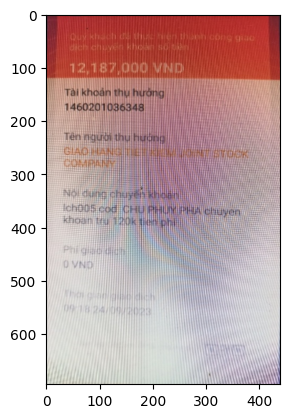

In [3]:
import os, cv2
import matplotlib.pyplot as plt 

image = cv2.imread("/home/fit/optivisionlab/scan-bill/dataset/money_keypoint_landmarks/agribank/images/val/c82b05902e4bc522c9a3091820e733f6.jpg")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [32]:
from skimage import io
from skimage import color, data, restoration
from scipy.signal import convolve2d
import numpy as np


image_rgb = io.imread("/home/fit/optivisionlab/scan-bill/dataset/money_keypoint_landmarks/agribank/images/val/c82b05902e4bc522c9a3091820e733f6.jpg")
deconvolved_channels = []
channels = np.split(image_rgb, 3, axis=2)
for camera in channels:
    camera = camera.reshape(695, 439)
    psf = np.ones((5, 5)) / 25
    camera = convolve2d(camera, psf, "same")
    camera += 0.1 * camera.std() * np.random.poisson(size=camera.shape)
    deconvolved = restoration.richardson_lucy(camera, psf, 30, False)
    # plt.matshow(camera, cmap="Greys_r")
    # plt.matshow(deconvolved, cmap="Greys_r", vmin=camera.min(), vmax=camera.max())
    deconvolved_channels.append(deconvolved)

In [ ]:
deconvolved_image = np.concatenate(deconvolved_channels, axis=2)
deconvolved_image.shape

In [37]:
deconvolved_channels = np.array(deconvolved_channels)
deconvolved_channels.reshape(695, 439, 3)
deconvolved_channels.T.shape

(439, 695, 3)

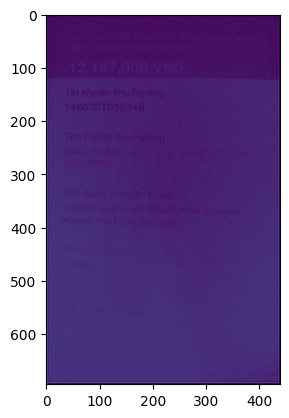

In [40]:
plt.imshow(deconvolved_channels[1])
plt.show()